# Analysis of trajectories with regards to system dynamics

I produced sets of trajectories for different values of ecosystem and trade income to see whether they resulted in a stable, trade supported society or predator prey cycles for society and ecosystem.

Therefore, I want to calculate some measure, that tell me whether the trajectories are primarily noise around a stable value or wheter they are oscillating in some sort of chaotic attractor.

First, lets see how the trajectories are saved.

In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
import seaborn as sns

from ipywidgets import IntProgress
from IPython.display import display

# from https://github.com/nikdon/pyEntropy
from pyentrp import entropy as entrp

In [3]:
# load data
path_to_data = '/home/jakob/Project_MayaSim/output_data/X10_trajectories/results/all_trjs.hd5'

with pd.HDFStore(path_to_data) as store:
    data = store.select('d1', where='step>500', columns=['total_population'])
data.index = data.index.droplevel('test')

In [4]:
# generate empty dataframe with same index (minus 'steps')
index = data.index
empty_df = pd.DataFrame(index=index, columns=['e']).sum(level=(0,1,2))
empty_df[['e']] = float('nan')

ann = pd.DataFrame(index=empty_df.index, columns=['ann'], data='').sum(level=(0, 1))

In [5]:
# calculate permutation entropy for trajectories for t>500 (after initial overshoot)
f = IntProgress(min=0, max=len(empty_df)) # instantiate a progress bar
display(f) # display the progress bar
i=0
for ind, row in empty_df.iterrows():
    # increase bar
    f.value += 1
    i += 1
    # check, if already calculated,
    if np.isnan(row['e']):
        # if not, load time series
        dft = data.loc[ind]

        # if timeseries contains data, calculate permutation entropy
        if len(dft.values[:,0])>0:
            e = entrp.permutation_entropy(dft.values[:,0], normalize=True)
        else:
            e = float('nan')
        # and save.
        empty_df.loc[ind, 'e'] = e

    

IntProgress(value=0, max=23374)

Time series of total population for different values of ecosystem income and a fixed value of trade income:

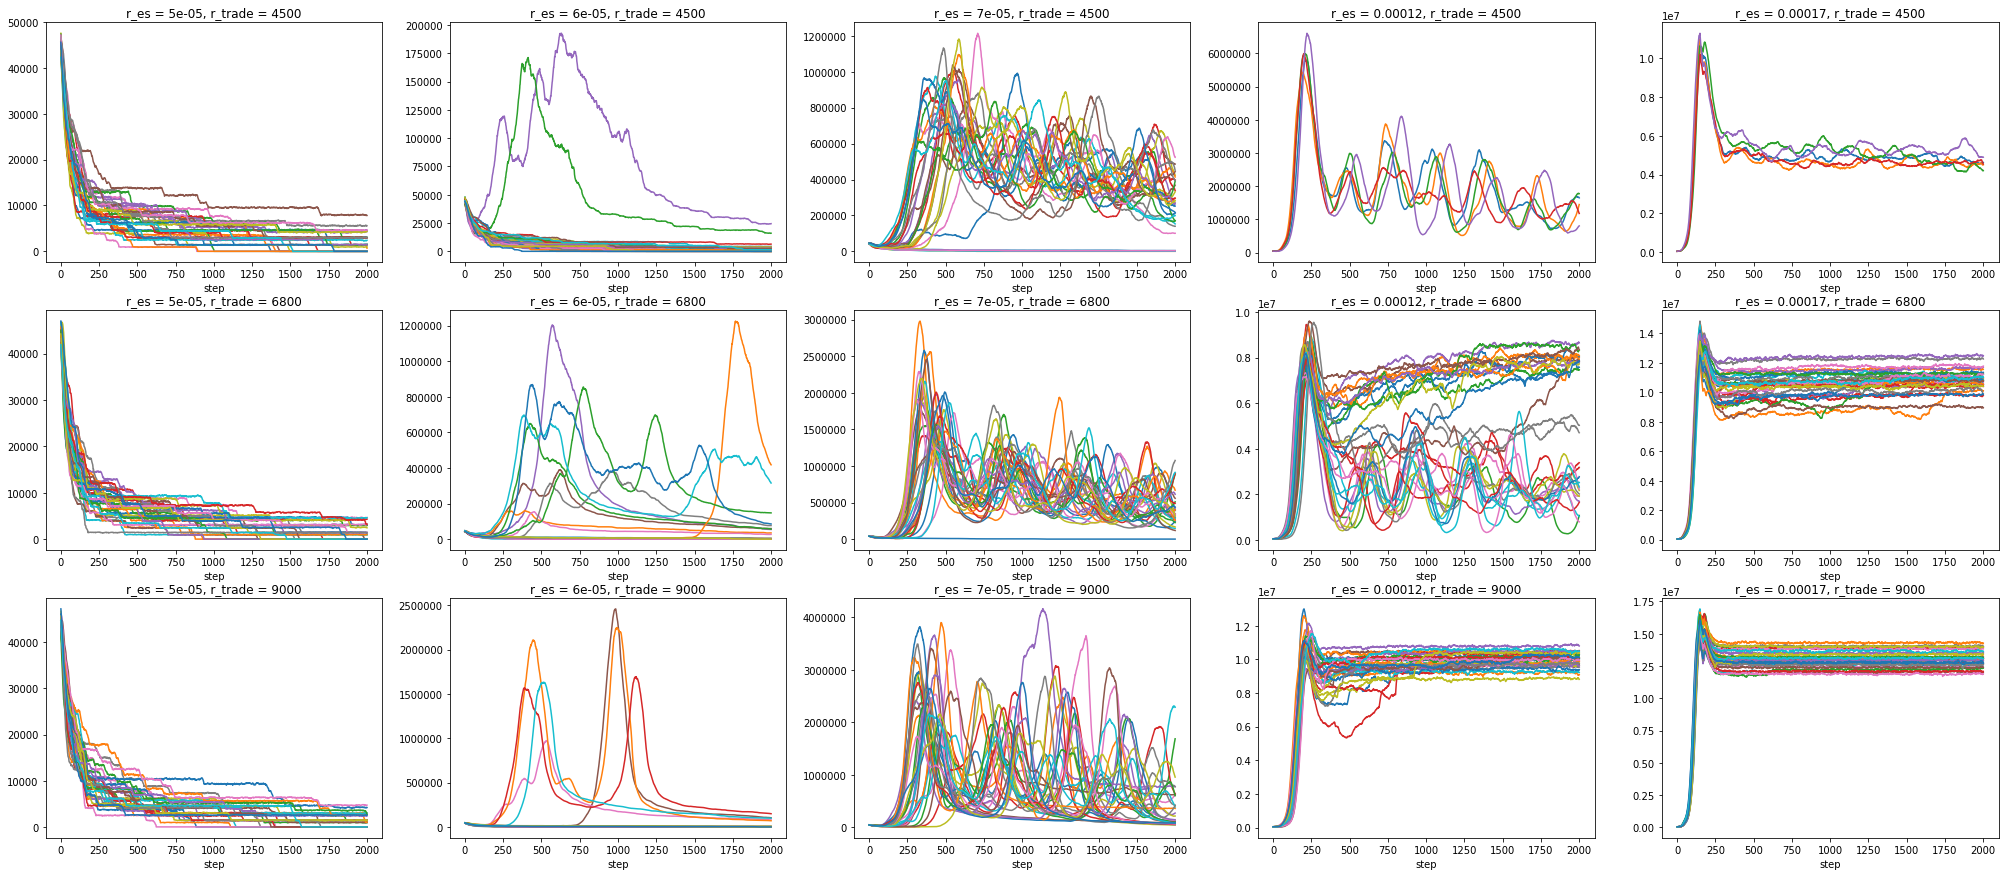

In [10]:
# plot trajectories for different values of r_es and r_trade
%matplotlib inline
import seaborn as sns
import itertools as it

r_ess = [5e-5, 6e-5, 7e-5, 0.00012, 0.00017]
r_trades=[4500, 6800, 9000]

fig, ax = plt.subplots(nrows=len(r_trades), ncols=len(r_ess))
fig.set_figwidth(7*len(r_ess))
fig.set_figheight(5*len(r_trades))

with pd.HDFStore('/home/jakob/Project_MayaSim/output_data/X10_trajectories/results/all_trjs.hd5') as store:
    df = store.select('d1', where=f'r_trade = {r_trades} & r_es = {r_ess}', columns=['total_population'])
    df.index = df.index.droplevel('test')


for ((i, r_es), (j, r_trade)) in it.product(enumerate(r_ess), enumerate(r_trades)):    
    ann.loc[(r_trade, r_es), 'ann'] = 'X'
    try:
        df.loc[(r_trade, r_es)].unstack('run_id').plot(ax=ax[j,i], legend=False)
        ax[j,i].set_title(f'r_es = {r_es}, r_trade = {r_trade}')
    except:
        print('no_data')
fig.savefig('trade_vs_es_trajectories.png')

The trajectories show that for different values of ecosystem income and trade icome, different patterns arise. For very low ecosystem income, the population dies out. For intermediate ecosystem income, oscillatory patterns appear, and for a certain (hight) combination of ecosystem income and trade, a set of high population states seems to be stable (except for small noise around them).

Then, I can compare this intuitive analysis to the result of the permutation entropy measure. And I can see that:
* for trajectories where population goes extinct, entropy is ~0
* for oscillating trajectories, the permutation entropy is ~1/2
* for stationary, noisy trajectories, the permutation entropy is ~1
* and in the range where both dynamic behaviors occur, it shows sort of a bimodal distribution.

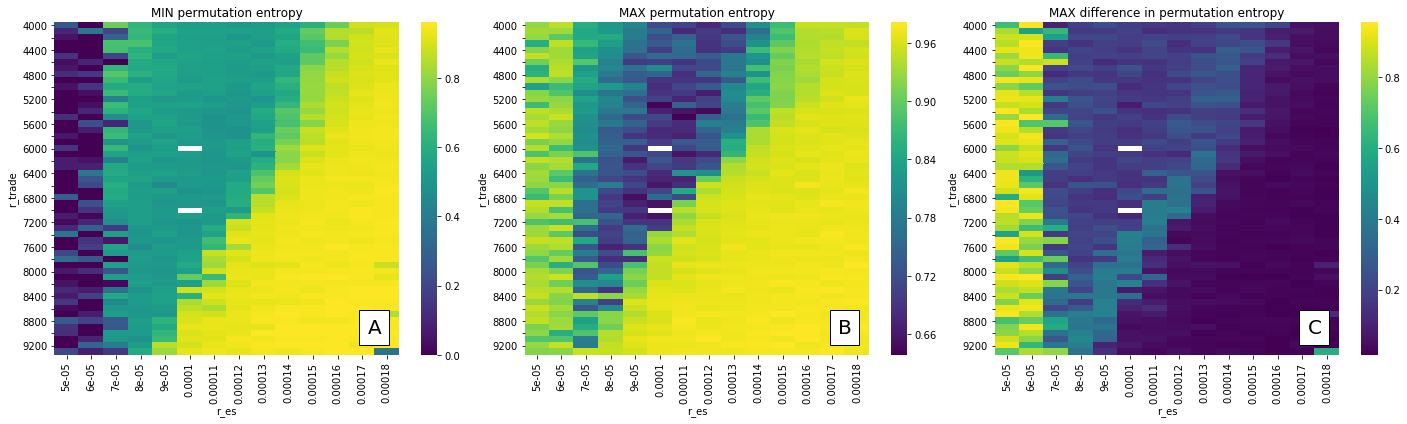

In [11]:
# plot heatmaps of permutation entropy for different values of r_es and r_trade
tmp = empty_df
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_figwidth(20)
fig.set_figheight(6)

results = tmp.min(level=[0,1])
results.unstack('r_es')
sns.heatmap(results['e'].unstack('r_es'), fmt='s', cmap='viridis', ax=ax[0], annot=ann.unstack('r_es'))
ax[0].set_title('MIN permutation entropy')

# results = tmp.mean(level=[0,1])
# results.unstack('r_es')
# sns.heatmap(results['e'].unstack('r_es'), fmt='s', cmap='viridis', ax=ax[1], annot=ann.unstack('r_es'))
# ax[1].set_title('MEAN permutation entropy')

results = tmp.max(level=[0,1])
results.unstack('r_es')
sns.heatmap(results['e'].unstack('r_es'), fmt='s', cmap='viridis', ax=ax[1], annot=ann.unstack('r_es'))
ax[1].set_title('MAX permutation entropy')


results = tmp.max(level=[0,1]) - tmp.min(level=[0,1])
results.unstack('r_es')
sns.heatmap(results['e'].unstack('r_es'), fmt='s', cmap='viridis', ax=ax[2], annot=ann.unstack('r_es'))
ax[2].set_title('MAX difference in permutation entropy')

def add_at(ax, t, loc=2):
    from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
    fp = dict(size=20)
    _at = AnchoredText(t, loc=loc, prop=fp, )
    ax.add_artist(_at)
    return _at

for x, no in zip(ax, ['A', 'B', 'C']):
    add_at(x, no, loc=4)
    for label in x.get_yaxis().get_ticklabels()[1::2]:
        label.set_visible(False)
        


fig.set_tight_layout(True)
fig.savefig('permutation_entropy.pdf')
fig.savefig('permutation entropy.png')

In the white regions, the runs on the somehow didn't finish whithin 24h. Have to look into this.

These results also show, that the default parameters of r_trade=6000 and r_es=0.0001 would be a good set of parameters to test drought events with an oscillating system.

**Bottom Line: The model shows four different regions in the r_es vs. r_trade parameter space with distinct boundaries.**

* convergence to zero total population
* oscillatory behavior
* convergence to a set of constant, high values for total population
* coexistence of the latter two

In [8]:
ann = pd.DataFrame(index=empty_df.index, columns=['ann'], data='').sum(level=(0, 1))